#Objective

Optimize the power consumption
of Zone 1 based on various environmental and
meteorological factors in
 Wellington, New-Zealand


#Importing Libraries|

In [1]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

# ML Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats

# Models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor


#Reading Data

In [2]:
df = pd.read_excel("City Power Consumption.xlsx")
df.head()

,S no,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Air Quality Index (PM),Cloudiness,Power Consumption in A Zone
0,1,6.559,73.8,0.083,0.051,0.119,158.0,1,34055.69620
1,2,6.414,74.5,0.083,0.070,0.085,159.0,1,29814.68354
2,3,6.313,74.5,0.080,0.062,0.100,151.0,1,29128.10127
3,4,6.121,75,0.083,0.091,0.096,151.0,1,28228.86076
4,5,5.921,75.7,0.081,0.048,0.085,154.0,1,27335.69620


In [3]:
df.columns

Index(['S no', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Air Quality Index (PM)',
       'Cloudiness', ' Power Consumption in A Zone'],
      dtype='object')

In [4]:
df.shape

(52583, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52583 entries, 0 to 52582
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   S no                          52583 non-null  int64  
 1   Temperature                   52263 non-null  object 
 2   Humidity                      52558 non-null  object 
 3   Wind Speed                    52512 non-null  float64
 4   general diffuse flows         52275 non-null  float64
 5   diffuse flows                 52568 non-null  float64
 6   Air Quality Index (PM)        52565 non-null  float64
 7   Cloudiness                    52583 non-null  int64  
 8    Power Consumption in A Zone  52583 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 3.6+ MB


#Data Cleaning

In [6]:
df.drop(['S no'],axis=1,inplace=True)
df.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Air Quality Index (PM),Cloudiness,Power Consumption in A Zone
0,6.559,73.8,0.083,0.051,0.119,158.0,1,34055.69620
1,6.414,74.5,0.083,0.070,0.085,159.0,1,29814.68354
2,6.313,74.5,0.080,0.062,0.100,151.0,1,29128.10127
3,6.121,75,0.083,0.091,0.096,151.0,1,28228.86076
4,5.921,75.7,0.081,0.048,0.085,154.0,1,27335.69620


In [7]:
df.rename(columns={
    'Wind Speed': 'Wind_Speed',
    'general diffuse flows': 'general_diffuse_flows',
    'diffuse flows': 'diffuse_flows',
    'Air Quality Index (PM)': 'Air_Quality_Index',
    ' Power Consumption in A Zone': 'Power'
}, inplace=True)

In [8]:
df['Temperature']=df['Temperature'].astype('str')
df['Temperature'] = df['Temperature'].str.extract(r'(\d+\.?\d*)', expand=False)
df['Temperature'] = pd.to_numeric(df['Temperature'])

In [9]:
df['Humidity']=df['Humidity'].astype('str')
df['Humidity'] = df['Humidity'].str.extract(r'(\d+\.?\d*)', expand=False)
df['Humidity'] = pd.to_numeric(df['Humidity'])

In [10]:
df.head()

,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,Air_Quality_Index,Cloudiness,Power
0,6.559,73.8,0.083,0.051,0.119,158.0,1,34055.69620
1,6.414,74.5,0.083,0.070,0.085,159.0,1,29814.68354
2,6.313,74.5,0.080,0.062,0.100,151.0,1,29128.10127
3,6.121,75.0,0.083,0.091,0.096,151.0,1,28228.86076
4,5.921,75.7,0.081,0.048,0.085,154.0,1,27335.69620


In [11]:
df.describe()

,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,Air_Quality_Index,Cloudiness,Power
count,52263.000000,52558.00000,52512.000000,52275.000000,52568.000000,52565.000000,52583.000000,52583.000000
mean,18.827384,68.28577,1.955320,182.964247,74.872330,154.499191,0.009338,31061.821779
std,5.813293,15.54517,2.347914,264.571351,124.084858,2.871553,0.096180,8021.057455
min,3.247000,11.34000,0.050000,0.004000,0.011000,150.000000,0.000000,9457.750760
25%,14.430000,58.33000,0.078000,0.062000,0.122000,152.000000,0.000000,24738.858990
50%,18.820000,69.88500,0.086000,5.226000,4.412000,155.000000,0.000000,31189.787230
75%,22.910000,81.40000,4.915000,320.100000,100.500000,157.000000,0.000000,36721.582445
max,40.010000,94.80000,6.483000,1163.000000,936.000000,159.000000,1.000000,52204.395120


In [12]:
#Missing Value
df.isnull().sum().sum()

np.int64(757)

In [13]:
print(df.isnull().sum())

Temperature              320
Humidity                  25
Wind_Speed                71
general_diffuse_flows    308
diffuse_flows             15
Air_Quality_Index         18
Cloudiness                 0
Power                      0
dtype: int64


In [14]:
df['Cloudiness'].nunique()

2

In [15]:
def outlier_percentage_iqr(df):
    outlier_percentages = {}
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        percentage = (len(outliers) / len(df)) * 100

        outlier_percentages[col] = round(percentage, 2)

    return pd.Series(outlier_percentages).sort_values(ascending=False)

In [16]:
outlier_percents = outlier_percentage_iqr(df)
print(outlier_percents)

diffuse_flows            8.77
general_diffuse_flows    4.31
Cloudiness               0.93
Humidity                 0.56
Temperature              0.27
Wind_Speed               0.00
Air_Quality_Index        0.00
Power                    0.00
dtype: float64


#Exploratory Data Analysis

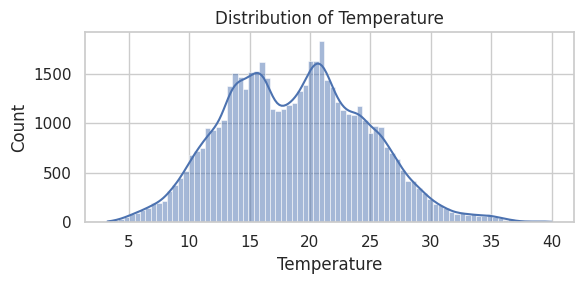

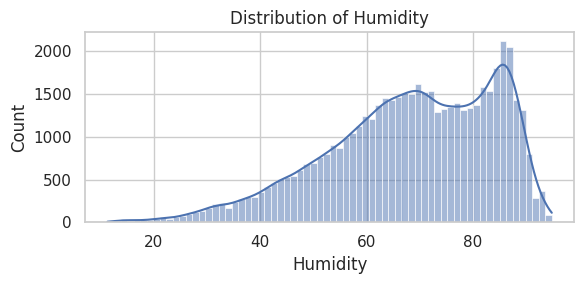

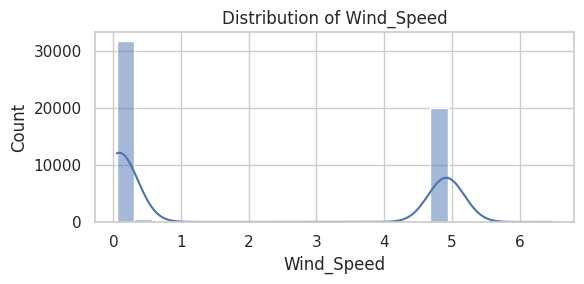

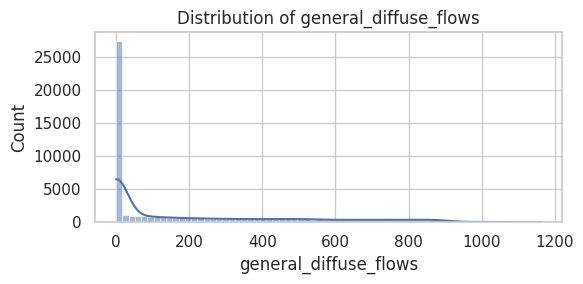

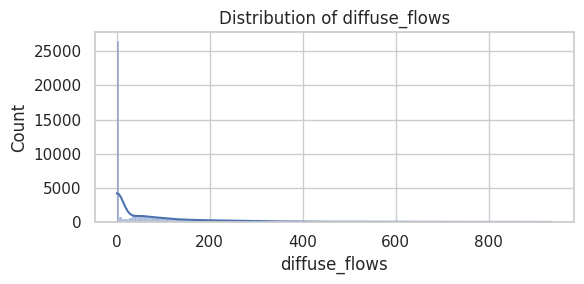

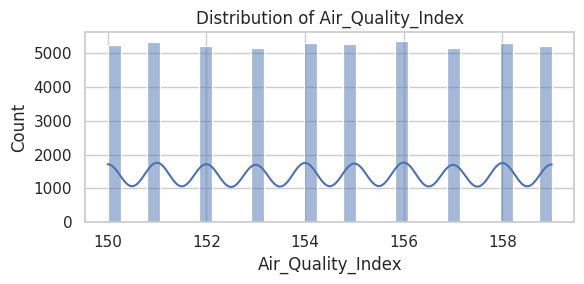

In [17]:
for col in ['Temperature', 'Humidity', 'Wind_Speed', 'general_diffuse_flows','diffuse_flows', 'Air_Quality_Index']:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

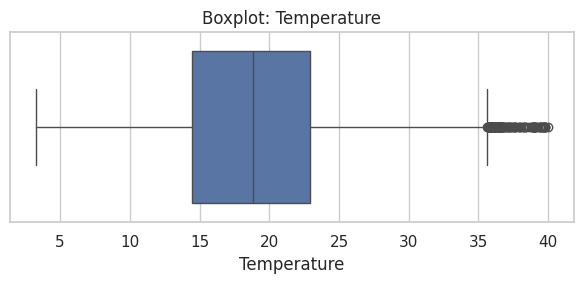

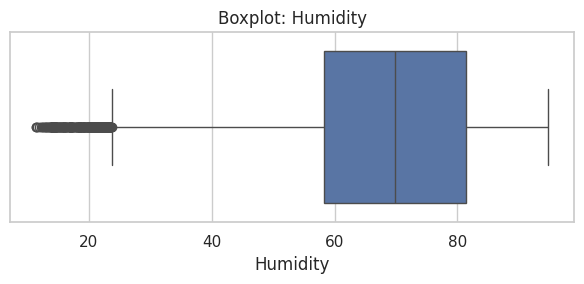

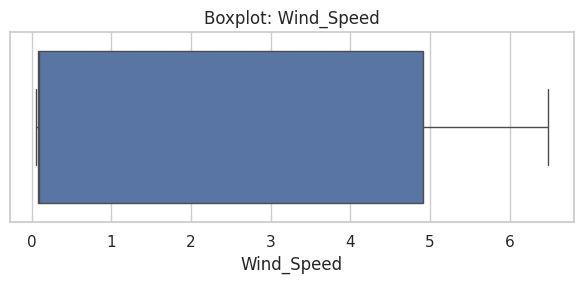

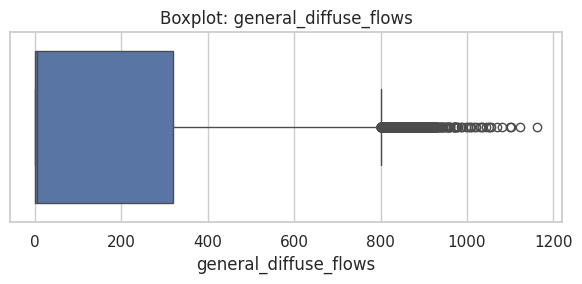

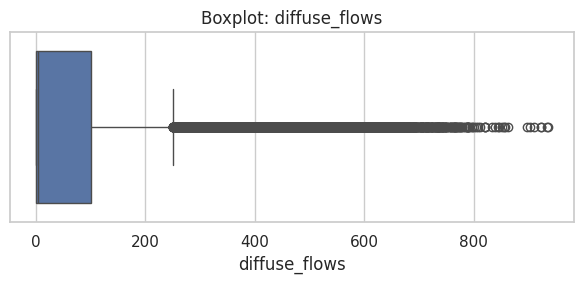

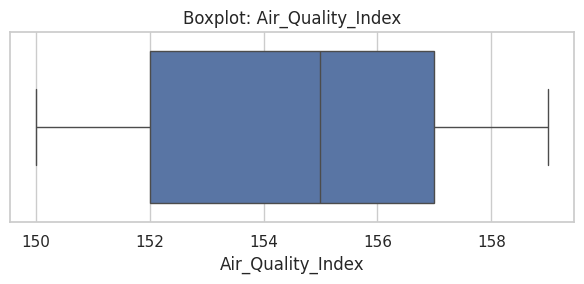

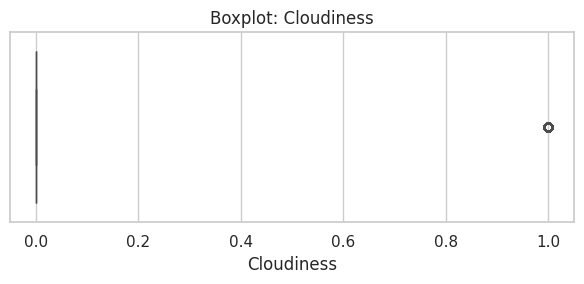

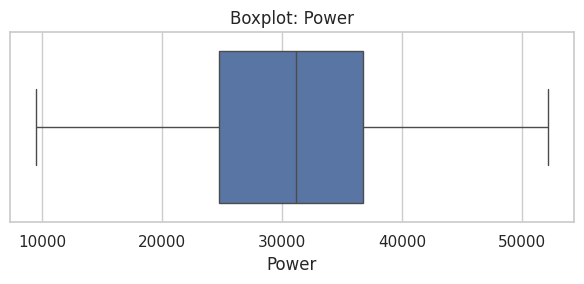

In [18]:
for col in df.columns:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

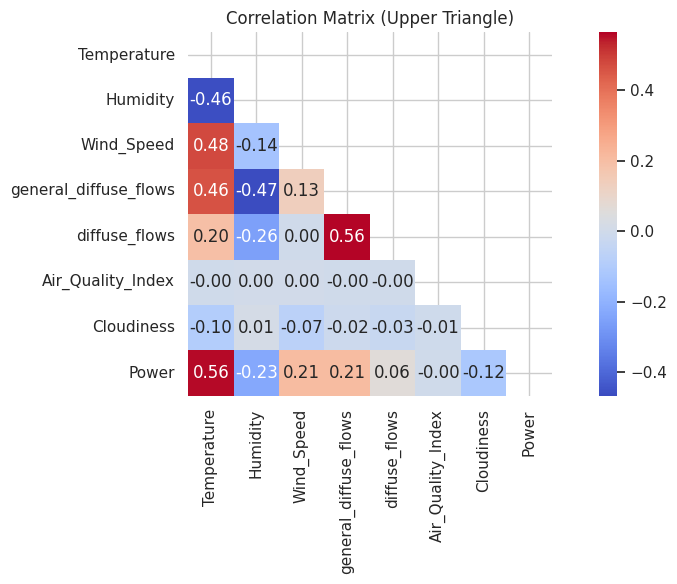

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    df.corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    mask=np.triu(df.corr())
)
plt.title("Correlation Matrix (Upper Triangle)")
plt.tight_layout()
plt.show()

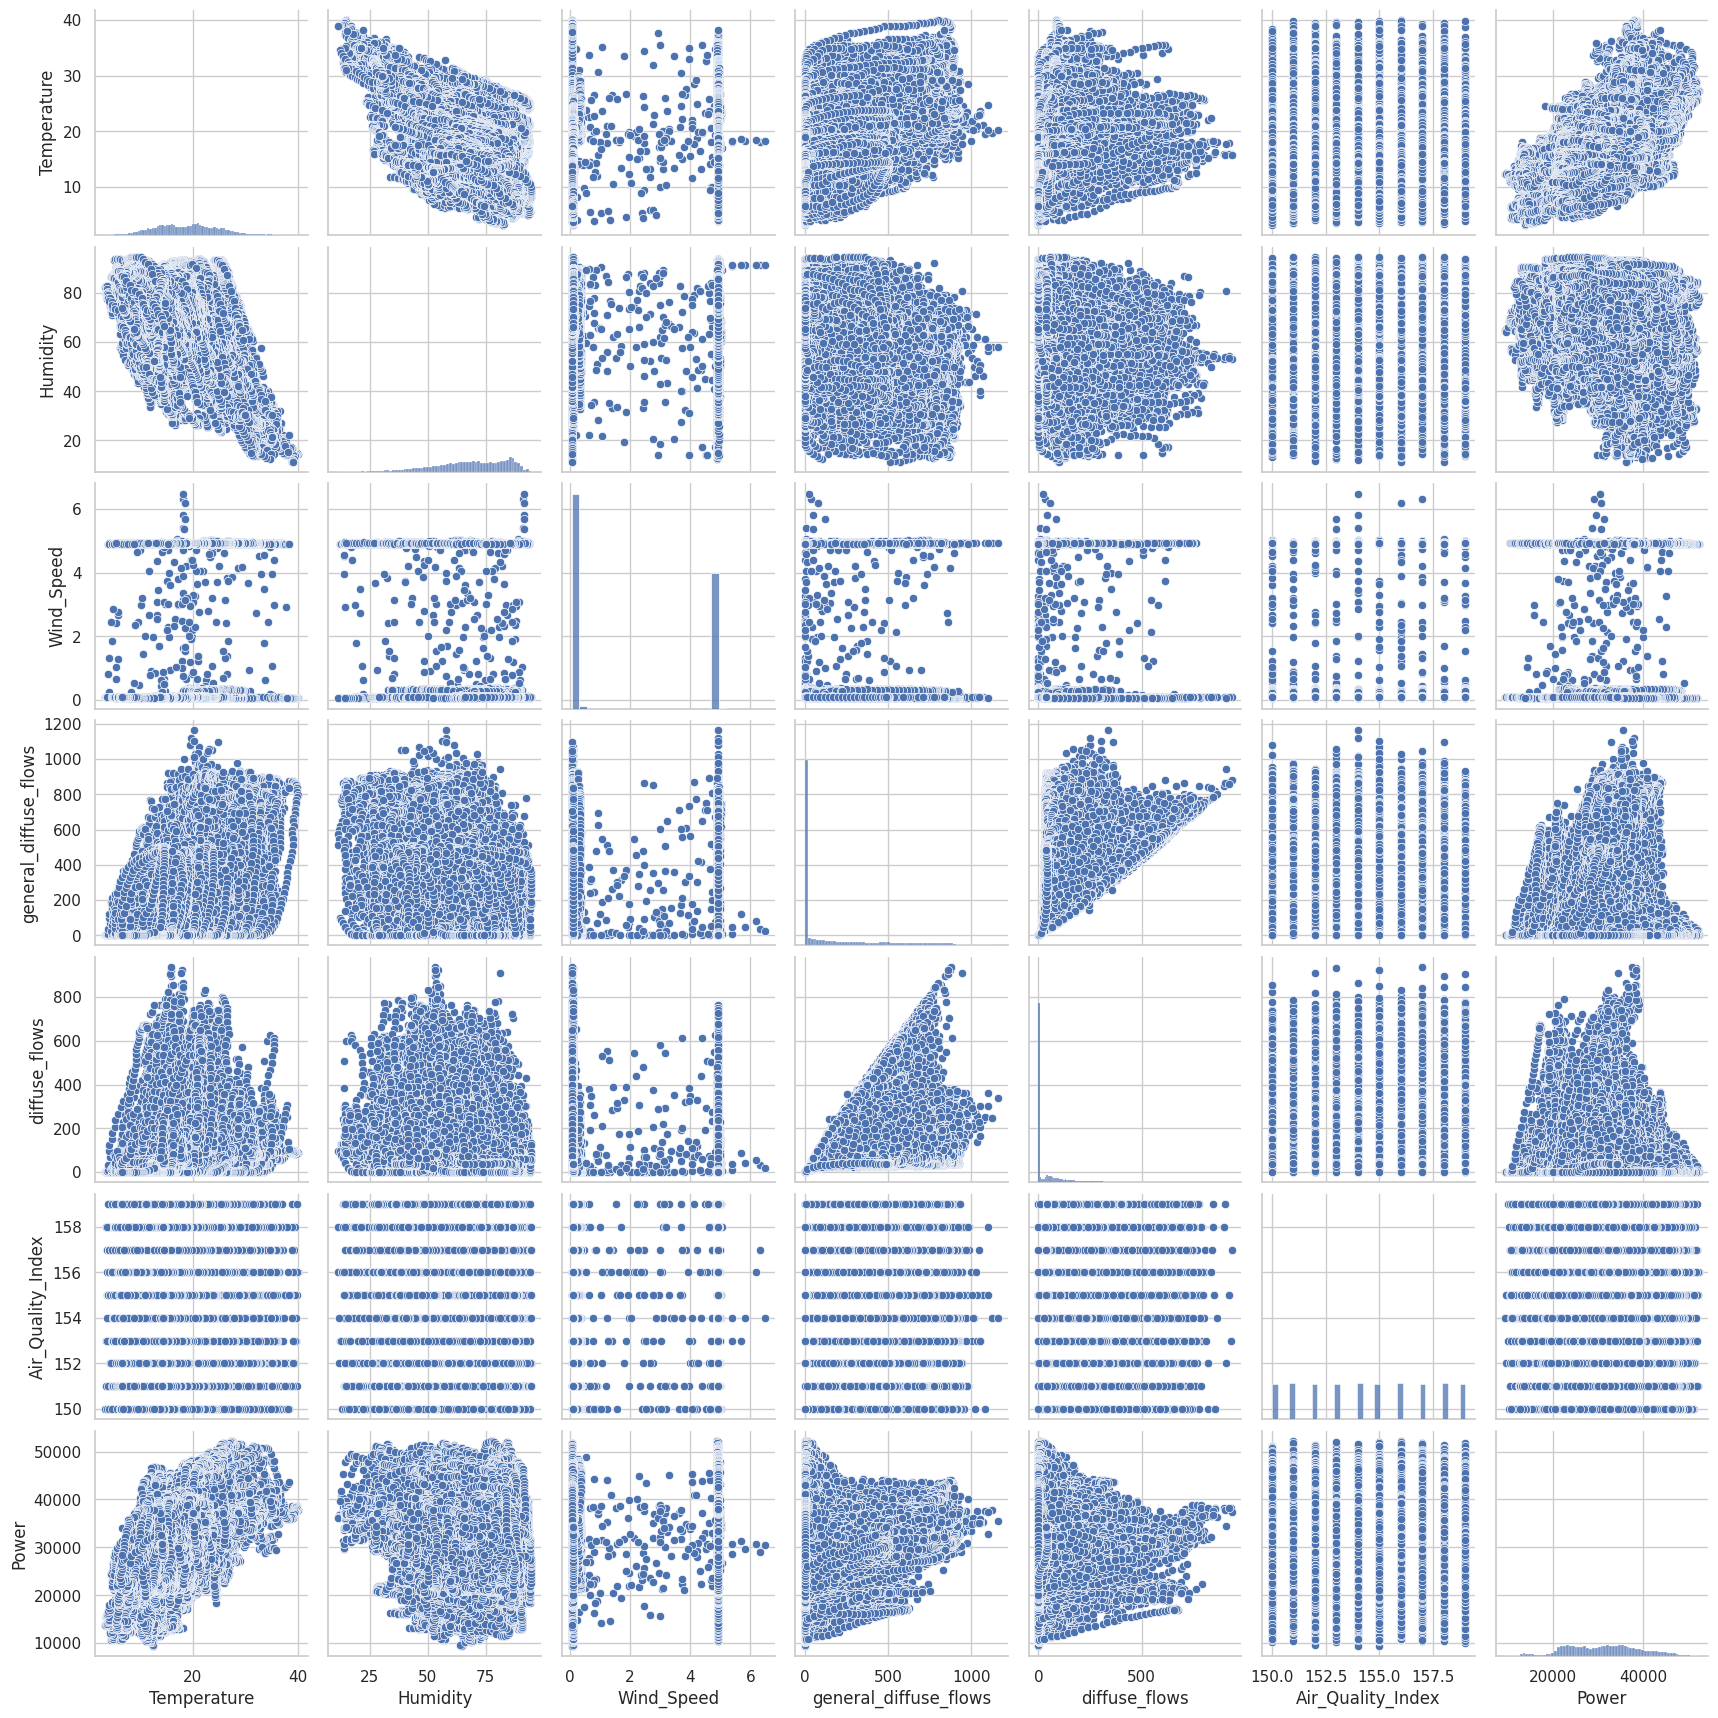

In [20]:
sns.pairplot(df[['Temperature', 'Humidity', 'Wind_Speed', 'general_diffuse_flows','diffuse_flows', 'Air_Quality_Index', 'Power']])

Pairplot Analysis Summary

- `general_diffuse_flows` and `diffuse_flows` show strong correlation
- `Temperature` has a mild nonlinear relationship with `Power`.
- Most features have weak or no visible linear relationship with the target.
- Distributions of features like `Air_Quality_Index` are narrow or discrete.

In [21]:
df['Cloudiness'].value_counts()

,count
Cloudiness,
0,52092
1,491


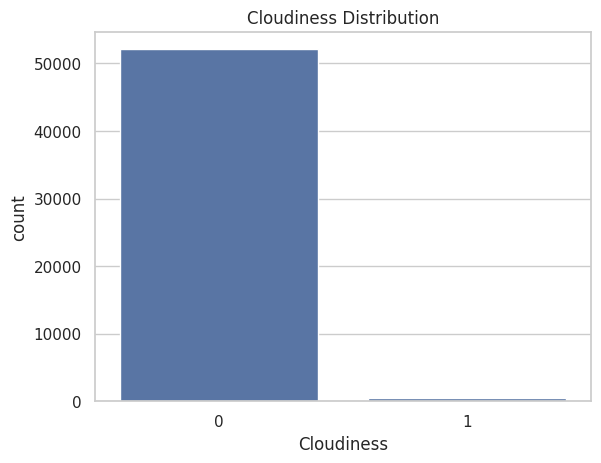

In [22]:
sns.countplot(x='Cloudiness', data=df)
plt.title('Cloudiness Distribution')
plt.show()

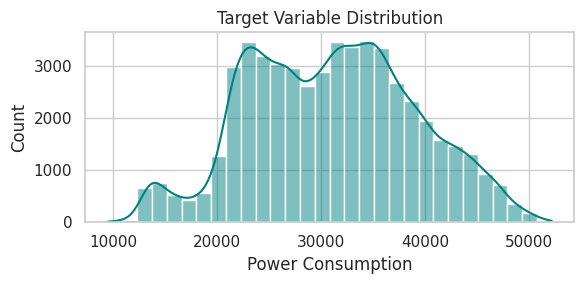

In [23]:
plt.figure(figsize=(6, 3))
sns.histplot(df["Power"], kde=True, bins=30, color='teal')
plt.title("Target Variable Distribution")
plt.xlabel("Power Consumption")
plt.tight_layout()
plt.show()

The target variable is right-skewed and multimodal, with most values between 20,000–40,000.
This indicates non-normality

#Data Preprocessing

In [24]:
#Outlier treatment
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower, lower,
                          np.where(df[column] > upper, upper, df[column]))
    return df

In [25]:
columns_to_cap = ['diffuse_flows', 'general_diffuse_flows']

for col in columns_to_cap:
    df = cap_outliers_iqr(df, col)

In [26]:
outlier_percents = outlier_percentage_iqr(df)
print("outliers_percents after treatment")
print(outlier_percents)

outliers_percents after treatment
Cloudiness               0.93
Humidity                 0.56
Temperature              0.27
Wind_Speed               0.00
general_diffuse_flows    0.00
diffuse_flows            0.00
Air_Quality_Index        0.00
Power                    0.00
dtype: float64


In [27]:
#Missing value Imputation
df['Temperature'] = df['Temperature'].fillna(df['Temperature'].median())
df['Humidity'] = df['Humidity'].fillna(df['Humidity'].median())
df['Wind_Speed'] = df['Wind_Speed'].fillna(df['Wind_Speed'].mean())
df['general_diffuse_flows'] = df['general_diffuse_flows'].fillna(df['general_diffuse_flows'].median())
df['diffuse_flows'] = df['diffuse_flows'].fillna(df['diffuse_flows'].median())
df['Air_Quality_Index'] = df['Air_Quality_Index'].fillna(df['Air_Quality_Index'].mean())

In [28]:
df.isnull().sum()

,0
Temperature,0
Humidity,0
Wind_Speed,0
general_diffuse_flows,0
diffuse_flows,0
Air_Quality_Index,0
Cloudiness,0
Power,0


In [29]:
skew_values = df.select_dtypes(include=['float64', 'int64']).skew()
print(skew_values)

Temperature               0.194395
Humidity                 -0.627581
Wind_Speed                0.466462
general_diffuse_flows     1.250918
diffuse_flows             1.204987
Air_Quality_Index        -0.001623
Cloudiness               10.203384
Power                     0.031528
dtype: float64


In [30]:
#To treat skewness
df['general_diffuse_flows'] = np.log1p(df['general_diffuse_flows'])
df['diffuse_flows'] = np.log1p(df['diffuse_flows'])

In [31]:
#Skew values after treatment
skew_values = df.select_dtypes(include=['float64', 'int64']).skew()
print(skew_values)

Temperature               0.194395
Humidity                 -0.627581
Wind_Speed                0.466462
general_diffuse_flows     0.204727
diffuse_flows             0.176754
Air_Quality_Index        -0.001623
Cloudiness               10.203384
Power                     0.031528
dtype: float64


In [32]:
df

,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,Air_Quality_Index,Cloudiness,Power
0,6.559,73.80,0.083,0.049742,0.112435,158.0,1,34055.69620
1,6.414,74.50,0.083,0.067659,0.081580,159.0,1,29814.68354
2,6.313,74.50,0.080,0.060154,0.095310,151.0,1,29128.10127
3,6.121,75.00,0.083,0.087095,0.091667,151.0,1,28228.86076
4,5.921,75.70,0.081,0.046884,0.081580,154.0,1,27335.69620
...,...,...,...,...,...,...,...,...
52578,18.820,75.60,0.094,6.080391,3.687879,157.0,0,34444.55696
52579,18.820,73.50,0.089,6.115009,3.656614,157.0,0,34438.48101
52580,18.820,70.10,0.085,6.147185,3.650398,157.0,0,33873.41772
52581,18.820,67.75,0.086,6.169611,3.647276,152.0,0,33988.86076


#Data Preparation

In [33]:
#Dependent independent separation
x=df.drop(["Power"],axis=1)
y=df["Power"]

In [34]:
x

,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,Air_Quality_Index,Cloudiness
0,6.559,73.80,0.083,0.049742,0.112435,158.0,1
1,6.414,74.50,0.083,0.067659,0.081580,159.0,1
2,6.313,74.50,0.080,0.060154,0.095310,151.0,1
3,6.121,75.00,0.083,0.087095,0.091667,151.0,1
4,5.921,75.70,0.081,0.046884,0.081580,154.0,1
...,...,...,...,...,...,...,...
52578,18.820,75.60,0.094,6.080391,3.687879,157.0,0
52579,18.820,73.50,0.089,6.115009,3.656614,157.0,0
52580,18.820,70.10,0.085,6.147185,3.650398,157.0,0
52581,18.820,67.75,0.086,6.169611,3.647276,152.0,0


In [35]:
y

,Power
0,34055.69620
1,29814.68354
2,29128.10127
3,28228.86076
4,27335.69620
...,...
52578,34444.55696
52579,34438.48101
52580,33873.41772
52581,33988.86076


In [36]:
#Train test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

#Feature Scaling

In [37]:
#feature scaling
numeric_cols = x_train.select_dtypes(include=['float64', 'int64']).columns.drop('Cloudiness')
scaler=StandardScaler()
x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

In [38]:
x_train

,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,Air_Quality_Index,Cloudiness
25421,1.091991,-0.067460,1.267544,1.405200,0.770988,1.222518,0
24106,0.599127,0.097521,-0.802399,1.320824,0.906094,-0.521490,0
16072,-0.123741,0.376770,-0.800694,1.100453,1.402110,0.176113,0
14948,-0.294947,0.575774,-0.801120,-0.083290,0.040184,-0.521490,0
19487,-0.099531,0.665647,1.264560,0.700703,1.014035,1.571319,0
...,...,...,...,...,...,...,...
11284,-1.444964,1.391051,-0.797283,0.359030,0.602220,1.571319,0
44732,0.478072,-0.307550,-0.799841,1.166042,1.402110,-0.172688,0
38158,0.716722,-1.167121,1.266265,-0.967171,-0.990436,-0.870292,0
860,-1.118117,0.524418,-0.796004,-0.978239,-0.982896,1.222518,0


In [39]:
round(x_train[numeric_cols].describe().T[['mean', 'std']],2)

,mean,std
Temperature,-0.0,1.0
Humidity,-0.0,1.0
Wind_Speed,0.0,1.0
general_diffuse_flows,0.0,1.0
diffuse_flows,0.0,1.0
Air_Quality_Index,0.0,1.0


#Base Model

In [40]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
dummy.fit(x_train, y_train)
y_pred_dummy = dummy.predict(x_test)

rmse_dummy =np.sqrt( mean_squared_error(y_test, y_pred_dummy))
r2_dummy = r2_score(y_test, y_pred_dummy)

print(f"Baseline (Mean) RMSE = {rmse_dummy:.2f}, R² = {r2_dummy:.4f}")

Baseline (Mean) RMSE = 8037.41, R² = -0.0000


“As a baseline, I used a DummyRegressor that predicts the mean of the training data. It achieved R² = -0.000 and RMSE = 8037.41. All further models were evaluated against this benchmark.”

In [41]:
#OLS model
x_train_const = sm.add_constant(x_train)

ols_model = sm.OLS(y_train, x_train_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     2883.
Date:                Fri, 11 Jul 2025   Prob (F-statistic):               0.00
Time:                        12:56:42   Log-Likelihood:            -4.2959e+05
No. Observations:               42066   AIC:                         8.592e+05
Df Residuals:                   42058   BIC:                         8.593e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.112e+

#Checking Linear regression assumptions

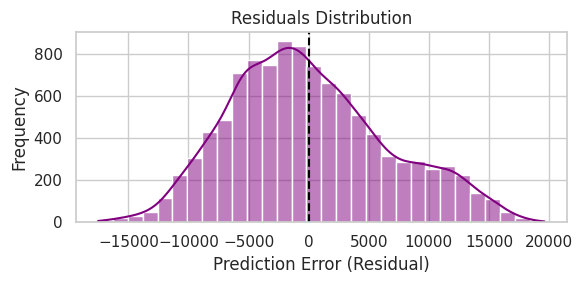

In [42]:
#Residual Histogram
model=LinearRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
residuals = y_test - y_pred
plt.figure(figsize=(6, 3))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

	Slight left skew, unimodal

residual vs predicted

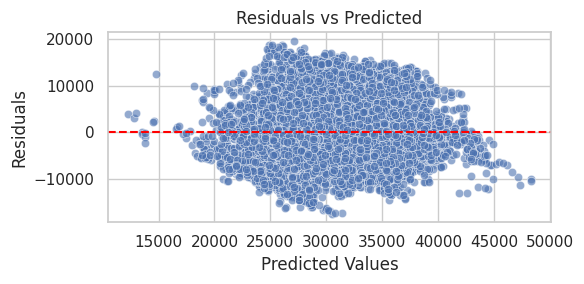

In [43]:
#Homoscedasticity
plt.figure(figsize=(6, 3))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

The residuals are randomly scattered around zero, with no visible patterns or curvature. There is a slight funneling in both ends. The residuals show slight heteroscedasticity.

QQ plot

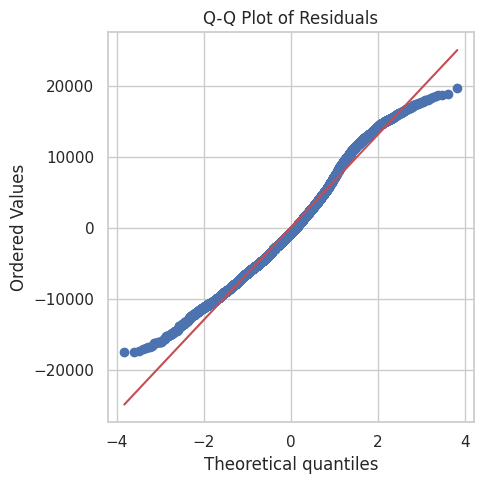

In [44]:
#Normality of residuals
plt.figure(figsize=(5, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

Normality of residuals is violated

In [45]:
correlations = x_train.corrwith(y_train).sort_values(ascending=False)
print(correlations)

Temperature              0.557043
Wind_Speed               0.202305
general_diffuse_flows    0.177756
diffuse_flows            0.152994
Air_Quality_Index       -0.002197
Cloudiness              -0.122572
Humidity                -0.227291
dtype: float64


In [46]:
#Checking Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
x_numeric = x_train.select_dtypes(include=['float64', 'int64']).copy()


x_numeric = x_numeric.loc[:, x_numeric.nunique() > 2]


vif_data = pd.DataFrame()
vif_data["Feature"] = x_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(x_numeric.values, i)
                   for i in range(x_numeric.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                 Feature        VIF
3  general_diffuse_flows  17.774064
4          diffuse_flows  16.499054
0            Temperature   1.747614
1               Humidity   1.430054
2             Wind_Speed   1.313397
5      Air_Quality_Index   1.000073


The presence of multicollinearity is confirmed.

#Polynomial Regression

In [47]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4, include_bias=False)

x_train_poly = poly.fit_transform(x_train)


x_test_poly = poly.transform(x_test)

model_poly = LinearRegression()
model_poly.fit(x_train_poly, y_train)

y_pred_poly = model_poly.predict(x_test_poly)

rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Polynomial Linear Regression (deg=4): RMSE = {rmse_poly:.2f}")

print("Train R²:", r2_score(y_train, model_poly.predict(x_train_poly)))
print("Test R² :", r2_score(y_test, model_poly.predict(x_test_poly)))

Polynomial Linear Regression (deg=4): RMSE = 6191.42
Train R²: 0.4109887769135616
Test R² : 0.4065958333200861


#Model Comparison

In [48]:
#model building
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'KNN Regressor':KNeighborsRegressor(n_neighbors=5)
}


results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'RMSE': round(rmse, 2),
        'R² Score': round(r2, 4)
    })

results_df = pd.DataFrame(results).sort_values(by='R² Score', ascending=False)
print(results_df)

               Model     RMSE  R² Score
4      Random Forest  4848.79    0.6361
5            XGBoost  5387.54    0.5507
6      KNN Regressor  6233.50    0.3985
2   Lasso Regression  6577.88    0.3302
1   Ridge Regression  6577.93    0.3302
0  Linear Regression  6577.95    0.3302
3      Decision Tree  6865.89    0.2703


#Hyperparameter Tuning

In [49]:
#Hyperparameter Tuning Random forest

rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=8,
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)

rf_random.fit(x_train, y_train)

# Best model
print("Best Random Forest Params:", rf_random.best_params_)
rf_best = rf_random.best_estimator_
rf_best.fit(x_train, y_train)
y_pred_rf = rf_best.predict(x_test)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


In [50]:
#Hyperparameter Tuning Xgboost
xgb = XGBRegressor(random_state=42, verbosity=0)

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=8,
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)

xgb_random.fit(x_train, y_train)
xgb_best = xgb_random.best_estimator_
print("Best XGB Params:", xgb_random.best_params_)
xgb_best.fit(x_train, y_train)
y_pred_xgb = xgb_best.predict(x_test)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best XGB Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [51]:
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

# XGBoost
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"Random Forest: RMSE = {rf_rmse:.2f}, R² = {rf_r2:.4f}")
print(f"XGBoost:       RMSE = {xgb_rmse:.2f}, R² = {xgb_r2:.4f}")

Random Forest: RMSE = 5177.27, R² = 0.5851
XGBoost:       RMSE = 5387.68, R² = 0.5507


#Feature Importance

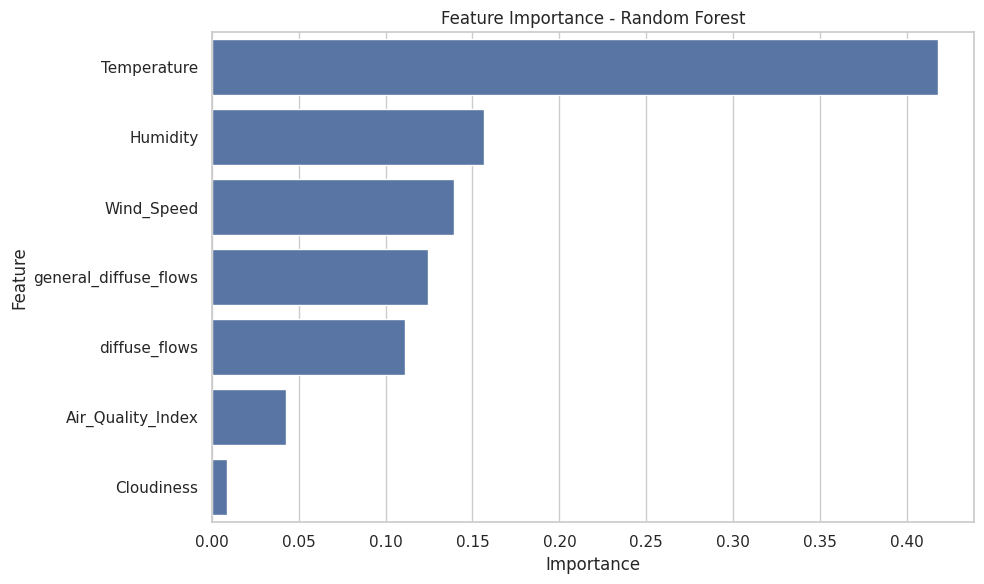

In [52]:
importances = rf_best.feature_importances_
features = x_train.columns

# Create DataFrame for better plotting
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

#Feature Selection

In [53]:
low_importance = feat_imp_df[feat_imp_df['Importance'] < 0.01]['Feature'].tolist()
print(low_importance)
x_train_reduced = x_train.drop(columns=low_importance)
x_test_reduced = x_test.drop(columns=low_importance)

['Cloudiness']


In [54]:
rf=RandomForestRegressor(random_state=42)
rf.fit(x_train_reduced,y_train)

y_pred_train=rf.predict(x_train_reduced)
rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_tr = r2_score(y_train, y_pred_train)
print("-------Training results------")
print("RMSE:", rmse_tr)
print("R²:", r2_tr)

r2_scores = cross_val_score(rf, x_train_reduced, y_train, cv=2, scoring='r2')
rmse_scores = cross_val_score(rf, x_train_reduced, y_train, cv=2, scoring='neg_root_mean_squared_error')
rmse_scores = -rmse_scores
print("-----crossvalidation results------")
print("Mean R²:", r2_scores.mean())
print("Mean RMSE:", rmse_scores.mean())


y_pred_rf=rf.predict(x_test_reduced)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)
print("--------Test results-------")
print(f"Random Forest: RMSE = {rmse:.2f}, R² = {r2:.4f}")


-------Training results------
RMSE: 1847.1027167766308
R²: 0.946914907136715
-----crossvalidation results------
Mean R²: 0.5681535521112506
Mean RMSE: 5268.105629707683
--------Test results-------
Random Forest: RMSE = 4898.50, R² = 0.6286


The model performance after feature selection is lower than base Random forest.

#Stacking Ensemble model

In [55]:

base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split= 2, min_samples_leaf= 1, max_features='log2', max_depth= 20)),
    ('xgb', XGBRegressor(subsample=1.0, n_estimators= 200, max_depth= 6, learning_rate=0.1, colsample_bytree= 1.0,random_state=42)),
]

meta_model =  XGBRegressor(n_estimators=100, random_state=42)


stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=2, passthrough=True)

In [56]:
stacked_model.fit(x_train, y_train)

y_pred_stack = stacked_model.predict(x_test)

rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacked Ensemble: RMSE = {rmse_stack:.2f}, R² = {r2_stack:.4f}")

Stacked Ensemble: RMSE = 5129.15, R² = 0.5928


#Final model

In [57]:
rf=RandomForestRegressor(random_state=42)
rf.fit(x_train,y_train)
y_pred_train=rf.predict(x_train)
rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_tr = r2_score(y_train, y_pred_train)
print("-------Training results------")
print("RMSE:", rmse_tr)
print("R²:", r2_tr)

r2_scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='r2')
rmse_scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -rmse_scores
print("-----crossvalidation results------")
print("Mean R²:", r2_scores.mean())
print("Mean RMSE:", rmse_scores.mean())


y_pred_rf=rf.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)
print("--------Test results-------")
print(f"RMSE = {rmse:.2f}")
print( f"R² = {r2:.4f}")

-------Training results------
RMSE: 1827.1884633027203
R²: 0.9480533941688487
-----crossvalidation results------
Mean R²: 0.6144206887349787
Mean RMSE: 4977.351896064214
--------Test results-------
RMSE = 4848.79
R² = 0.6361


#Conclusion

I tested advanced ensemble techniques including stacking with passthrough and an XGBoost meta-model, using tuned base regressors. However, Random Forest alone performed best, achieving R² = 0.6361, and was selected as the final model for its generalization and simplicity.